In [1]:
import sys
sys.path.insert(0, '../src')

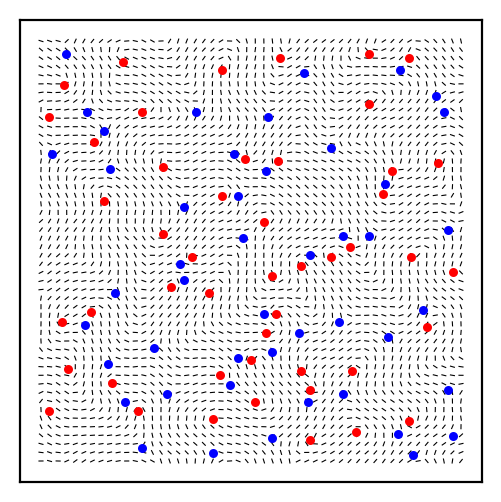

In [2]:
from skimage.transform import downscale_local_mean
from scipy.interpolate import interp2d
from defects import defect_coordinates
from winding import winding
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_axis(ax, sincos, skip=4):
    twoT = np.arctan2(sincos[0], sincos[1])
    theta = twoT / 2
    theta[theta < 0] += np.pi
    theta[theta > np.pi] -= np.pi
    
    defs = defect_coordinates(theta)
    wind = winding(theta)
    charge = -wind[defs[:, 1], defs[:, 0]]
    defs = defs / sincos.shape[-1]
    
    x, y = np.meshgrid(
        np.linspace(0, 1, sincos.shape[-1]//skip),
        np.linspace(0, 1, sincos.shape[-1]//skip))
    slc = np.s_[::skip, ::skip]
    ax.quiver(x, y, np.cos(theta)[slc], np.sin(theta)[slc], pivot='middle',
              headwidth=0, headlength=0, headaxislength=0)
    ax.scatter(defs[charge > 0, 0], defs[charge > 0, 1], color='red', s=5)
    ax.scatter(defs[charge < 0, 0], defs[charge < 0, 1], color='blue', s=5)
    ax.set(xticks=[], yticks=[])
    ax.set_aspect('equal')

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)
import h5py
with h5py.File('../../data/activity_assay/z0.02.hdf5', 'r') as h5f:
    director = h5f['director'][0]
    sincos = np.stack([
        2*director[0]*director[1],
        director[0]**2-director[1]**2
    ])
    plot_axis(ax, sincos)

In [11]:
import pandas as pd

def convert_sincos_theta(sincos):
    twoT = np.arctan2(sincos[:, 0], sincos[:, 1])
    theta = twoT / 2
    theta[theta < 0] += np.pi
    theta[theta > np.pi] -= np.pi
    return theta

def dot_product(theta1, theta2):
    return np.average(np.abs(
        (np.cos(theta1) * np.cos(theta2) + np.sin(theta1) * np.sin(theta2))), axis=(-2, -1))

def spatial_correlation_qij(theta, d=1.):
    nx = np.cos(theta)
    ny = np.sin(theta)

    qxx = nx * nx
    qyy = ny * ny
    qxy = nx * ny

    # FFT since sims have periodic boundary
    Ftxx = np.fft.fft2(qxx)
    Ftyy = np.fft.fft2(qyy)
    Ftxy = np.fft.fft2(qxy)

    prodxx = Ftxx * np.conjugate(Ftxx)
    prodyy = Ftyy * np.conjugate(Ftyy)
    prodxy = Ftxy * np.conjugate(Ftxy)

    tp = (np.fft.ifft2(prodxx + prodyy + 2 * prodxy).real / (theta.shape[0] * theta.shape[1]) - 0.5) * 2
    
    return vec_to_scalar_func(tp, d=d)[:int(theta.shape[0]/2), 1]

def vec_to_scalar_func(grid, d=1.):
    x, y = np.mgrid[:grid.shape[0], :grid.shape[1]]
    mag = np.sqrt(x**2 + y**2)
    mxv = np.max(mag)
    vls = np.arange(0., mxv, d)
    ret = np.zeros(int(mxv/d)+1)

    for i in range(len(ret)):
        ret[i] = np.mean(grid[np.abs(mag - vls[i]) <= d/2.])
    ret[np.isnan(ret)] = 0.
    return np.stack((vls, ret), axis=1)

def mean_defect_spacing(theta):
    defects = defect_coordinates(theta)
    return defects.shape[0]

def time_correlation_qij(theta):
    nx = np.cos(theta)
    ny = np.sin(theta)

    qxx = nx * nx
    qyy = ny * ny
    qxy = nx * ny

    c0T = qxx[0]*qxx + qyy[0]*qyy + 2*qxy[0]*qxy
    c0T = 2*c0T - 1
    c0T /= c0T[0]
    c0T = np.mean(c0T, axis=(-2, -1))

    return c0T

def make_processed_df(model, sample, dt=10, z=0.025, stitch_ratio=-1, input_size=48):
    with torch.no_grad():
        if stitch_ratio == -1:
            sample = sample[...,:input_size, :input_size]
        inputs = sample[:7]
        target = sample[7:]


        pred1 = predict_model(model, inputs.clone(), tmax=target.shape[0], 
                              input_size=input_size, stitch_ratio=stitch_ratio)
        pred1 = torch.FloatTensor(np.stack([
            np.sin(2*pred1),
            np.cos(2*pred1),
        ], axis=1)).to(device)

        target = target.cpu().numpy()
        pred = pred1.cpu().numpy()
    
    theta0 = convert_sincos_theta(target)
    theta1 = convert_sincos_theta(pred)

    nd0 = np.array([mean_defect_spacing(theta0[i]) for i in range(theta0.shape[0])])
    nd1 = np.array([mean_defect_spacing(theta1[i]) for i in range(theta1.shape[0])])

    lc0 = np.array([spatial_correlation_qij(theta0[i]) for i in range(theta0.shape[0])])
    lc1 = np.array([spatial_correlation_qij(theta1[i]) for i in range(theta1.shape[0])])

    lc0 = np.array([np.argwhere(f1 < 0.5)[0][0] for f1 in lc0])
    lc1 = np.array([np.argwhere(f1 < 0.5)[0][0] for f1 in lc1])

    tc0 = time_correlation_qij(theta0)
    tc1 = time_correlation_qij(theta1)

    tc0 = np.argwhere(tc0 < 0.5)[0][0]
    tc1 = np.argwhere(tc1 < 0.5)[0][0]

    df = pd.DataFrame({
        'dot_product': dot_product(theta0, theta1),
        'n_defects_LB': nd0,
        'n_defects_ML': nd1,
        'lc_LB': lc0,
        'lc_ML': lc1,
        'tcT_LB': tc0,
        'tcT_ML': tc1,
        't': np.arange(theta0.shape[0]) * dt
    })
    df['z'] = z

    return df

In [21]:
import torch
from res_ae_convnext import ConvNextFramePredictor
import sharpen
from dataset import *
from torchvision.transforms import Compose
transform = Compose([
    SinCos(),
	ToTensor()
])

device = torch.device('cuda:0')
model_dir = '../models/ConvNextFramePredictor_v1'
info = torch.load(f'{model_dir}/model_weight.ckpt', map_location='cpu', weights_only=True)
model = ConvNextFramePredictor().to(device) # Can do stitch_ratio=-1, input_size=200 because it's fully convolutional
model.load_state_dict(info['state_dict'])
model.eval()

def predict_model(model, inputs, tmax=1, input_size=48, stitch_ratio=-1):
    pred = sharpen.loop_frame_prediction(model, inputs, device, input_size=input_size,
                                         n=tmax, stitch_ratio=stitch_ratio, border=3, nsharp=1)
    return pred

z = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05]

dfs = []
for zi in z:
    ds = NematicsSequenceDataset(f'../../data/activity_assay/z{zi}.hdf5', frames_per_seq=7+50, transform=transform)
    for i in range(5):
        sample = ds[np.random.choice(len(ds))].to(device)
        try:
            df1 = make_processed_df(model, sample, z=zi, stitch_ratio=-1, input_size=200) # Lower activities are ~stationary, time corelation breaks
            dfs.append(df1)
        except Exception as e:
            print(e)
            continue

df_all = pd.concat(dfs, ignore_index=True)
df_all.to_csv(f'{model_dir}/prediction_statistics.csv')

INFO:dataset:Found director field at ../../data/activity_assay/z0.01.hdf5 with 543 sequences
INFO:dataset:Found director field at ../../data/activity_assay/z0.015.hdf5 with 543 sequences
INFO:dataset:Found director field at ../../data/activity_assay/z0.02.hdf5 with 543 sequences
INFO:dataset:Found director field at ../../data/activity_assay/z0.025.hdf5 with 543 sequences
INFO:dataset:Found director field at ../../data/activity_assay/z0.03.hdf5 with 543 sequences
INFO:dataset:Found director field at ../../data/activity_assay/z0.035.hdf5 with 543 sequences
INFO:dataset:Found director field at ../../data/activity_assay/z0.04.hdf5 with 543 sequences
INFO:dataset:Found director field at ../../data/activity_assay/z0.05.hdf5 with 543 sequences


In [13]:
import torch
from res_ae import ResidualFramePredictor
import sharpen
from dataset import *
from torchvision.transforms import Compose
transform = Compose([
    SinCos(),
	ToTensor()
])


device = torch.device('cuda:0')
model_dir = '../models/ResidualFramePredictor_v1'
info = torch.load(f'{model_dir}/model_weight.ckpt', map_location='cpu', weights_only=True)
model = ResidualFramePredictor().to(device) # Can do stitch_ratio=0.05, input_size=48
model.load_state_dict(info['state_dict'])
model.eval()

def predict_model(model, inputs, tmax=1, input_size=48, stitch_ratio=-1):
    pred = sharpen.loop_frame_prediction(model, inputs, device, input_size=input_size,
                                         n=tmax, stitch_ratio=stitch_ratio, border=3, nsharp=1)
    return pred

z = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05] # Lower activities are ~stationary, time corelation breaks

dfs = []
for zi in z:
    ds = NematicsSequenceDataset(f'../../data/activity_assay/z{zi}.hdf5', frames_per_seq=7+50, transform=transform)
    for i in range(5):
        sample = ds[np.random.choice(len(ds))].to(device)
        try:
            df1 = make_processed_df(model, sample, z=zi, stitch_ratio=.05, input_size=48)
            dfs.append(df1)
        except Exception as e:
            print(e)
            continue

df_all = pd.concat(dfs, ignore_index=True)
df_all.to_csv(f'{model_dir}/prediction_statistics.csv')

INFO:dataset:Found director field at ../../data/activity_assay/z0.01.hdf5 with 543 sequences
INFO:dataset:Found director field at ../../data/activity_assay/z0.015.hdf5 with 543 sequences
INFO:dataset:Found director field at ../../data/activity_assay/z0.02.hdf5 with 543 sequences
INFO:dataset:Found director field at ../../data/activity_assay/z0.025.hdf5 with 543 sequences
INFO:dataset:Found director field at ../../data/activity_assay/z0.03.hdf5 with 543 sequences
INFO:dataset:Found director field at ../../data/activity_assay/z0.035.hdf5 with 543 sequences
INFO:dataset:Found director field at ../../data/activity_assay/z0.04.hdf5 with 543 sequences
INFO:dataset:Found director field at ../../data/activity_assay/z0.05.hdf5 with 543 sequences
